# Решение турнирной задачи внутри отдела

## 1. Введение

Представлен датасет, содержащий различных комментарии, кластеризованные в зависимости от содержания на токсичные и нейтральные.
<br>

Необходимо составить модель ML, определяющая комментарий к той или иной группе.

Ключевая метрика - f1-мера

------

## 2. Первичное знакомство с данными

Установка библиотек (опционально, при отсутствии):

In [1]:
# pip install pandas seaborn matplotlib scipy tabulate scikit-learn plotly keras tensorflow
# nltk.download('wordnet')

Импорт библиотек:

In [42]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

Считываем файл CSV:

In [3]:
PATH = 'toxic_comments.csv'

In [4]:
df_init = pd.read_csv(PATH)

Выведем первые и последние 5 строк:

In [5]:
df_init.head()

,Unnamed: 0,text,toxic
0,0,Explanation\r\nWhy the edits made under my use...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\r\nMore\r\nI can't make any real suggestions...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [6]:
df_init.tail()

,Unnamed: 0,text,toxic
159287,159446,""":::::And for the second time of asking, when ...",0
159288,159447,You should be ashamed of yourself \r\n\r\nThat...,0
159289,159448,"Spitzer \r\n\r\nUmm, theres no actual article ...",0
159290,159449,And it looks like it was actually you who put ...,0
159291,159450,"""\r\nAnd ... I really don't think you understa...",0


Выведем основную информацию о датафрейме:

In [7]:
df_init.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [8]:
df_init.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,159292.0,79725.697242,46028.837471,0.0,39872.75,79721.5,119573.25,159450.0
toxic,159292.0,0.101612,0.302139,0.0,0.00,0.0,0.00,1.0


Проверим наличие пропусков данных:

In [9]:
df_init.isna().sum()

Unnamed: 0    0
text          0
toxic         0
dtype: int64

Проверим наличие дубликатов:

In [10]:
df_init.duplicated().mean()

0.0

**Выводы:**

- Данные состоят только из трех столбцов
- Столбец `Unnamed:0` на первый взгляд не содержит полезной информации
- Данные не содержат дубликатов
- Комментарии содержат большое количество символов и слов, не несущих смысловой нагрузки

----

## 3. Первичный исследовательский анализ

### 3.1 Предобработаем исходные данные:

In [11]:
df = df_init.copy()

Удалим ненужные столбцы:

In [26]:
df = df.drop(labels=['Unnamed: 0'], axis=1).copy()

Обработаем текст комментариев:

In [18]:
def clean_text(text):
    # Приведение к нижнему регистру
    text = text.lower()
    
    # Удаление пунктуации
    text = re.sub(r'[^\w\s]', '', text)
    
    # Удаление стоп-слов
    stop_words = set(stopwords.words('english'))
    words = text.split()
    words = [word for word in words if word not in stop_words]
    
    # Лемматизация
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    
    # Объединение слов обратно в текст
    cleaned_text = ' '.join(words)
    
    return cleaned_text


In [19]:
df['cleaned_comment'] = df['text'].apply(clean_text)

### 3.2 Подготовим даные

Теперь, когда наши входные данные стали более разумными, давайте преобразуем их так, чтобы наша модель могла их понять:
* Токенизация предложений в список отдельных слов
* Изучение свойств получившегося датасета
* Создание тестового и обучающего сета 

токенизируем предложения:

In [20]:
tokenizer = RegexpTokenizer(r'\w+')
df["tokens"] = df["cleaned_comment"].apply(tokenizer.tokenize)

посмотрим на получившийся результат:

In [21]:
df.head()

,Unnamed: 0,text,toxic,cleaned_comment,tokens
0,0,Explanation\r\nWhy the edits made under my use...,0,explanation edits made username hardcore metal...,"[explanation, edits, made, username, hardcore,..."
1,1,D'aww! He matches this background colour I'm s...,0,daww match background colour im seemingly stuc...,"[daww, match, background, colour, im, seemingl..."
2,2,"Hey man, I'm really not trying to edit war. It...",0,hey man im really trying edit war guy constant...,"[hey, man, im, really, trying, edit, war, guy,..."
3,3,"""\r\nMore\r\nI can't make any real suggestions...",0,cant make real suggestion improvement wondered...,"[cant, make, real, suggestion, improvement, wo..."
4,4,"You, sir, are my hero. Any chance you remember...",0,sir hero chance remember page thats,"[sir, hero, chance, remember, page, thats]"


### 3.3 Изучим детальнее наш датасет

Посмотрим на баланс классов:

In [22]:
df.groupby("toxic").count()

,Unnamed: 0,text,cleaned_comment,tokens
toxic,,,,
0,143106,143106,143106,143106
1,16186,16186,16186,16186


*Видим явный дисбаланс классов с избыточной выборкой "не токсичных" комментариев.*

#### Выведем информацию о комментариях:

In [29]:
all_words = [word for tokens in df["tokens"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in df["tokens"]]
VOCAB = sorted(list(set(all_words)))
print(f"Всего {len(all_words)} слов\nУникальных токенов словаре: {len(VOCAB)}\nНаибольшая длина комментария: {max(sentence_lengths)}")

Всего 5565177 слов
Уникальных токенов словаре: 239367
Наибольшая длина комментария: 1250


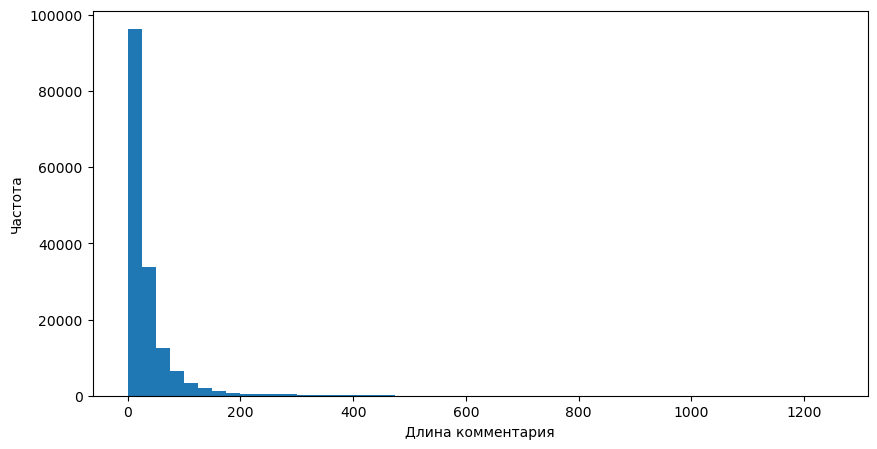

In [40]:
fig = plt.figure(figsize=(10, 5)) 
plt.xlabel('Длина комментария')
plt.ylabel('Частота')
plt.hist(sentence_lengths, bins=50)
plt.show()

### 4. Перейдем непорседственно к машинному обучению:

Естественным способом представления текста для компьютеров является кодирование каждого символа отдельно, однако это кажется крайне неадекватным для представления и понимания языка. Нашей целью является создание полезного встраивания для каждого предложения в нашем наборе данных, а затем использование этих встраиваний для точного предсказания соответствующей категории.

Самый простой подход, с которого мы можем начать, - это использование модели "мешка слов" (bag of words) и применение логистической регрессии сверху. Модель "мешка слов" просто сопоставляет индекс каждому слову в нашем словаре и встраивает каждое предложение в список из 0, с 1 в каждом индексе, соответствующем слову, присутствующему в предложении.

In [43]:
def vectorize_text_data(data):
    count_vectorizer = CountVectorizer()

    emb = count_vectorizer.fit_transform(data)

    return emb, count_vectorizer

In [44]:
list_corpus = df["cleaned_comment"].tolist()
list_labels = df["toxic"].tolist()

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, 
                                                                                random_state=40)

X_train_counts, count_vectorizer = vectorize_text_data(X_train)
X_test_counts = count_vectorizer.transform(X_test)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(df_preprocessing['cleaned_comment'], df_preprocessing['toxic'], test_size=0.2, random_state=42)

In [17]:
model_tfidf = make_pipeline(TfidfVectorizer(), LogisticRegression(max_iter=1000))
model_tfidf.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [18]:
y_pred = model_tfidf.predict(X_test)
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1*100}')

F1 Score: 73.08567096285064


*Как показывает гистограмма, машины, побывавшие в ремонте значительно дешевле. Высокобюджетные автомобили практически не бывают в ремонте*

### Выводы:

1. Мы почистили данные от выбросов 
2. Заполнили пропуски
3. Избавились от дубликатов
4. Проанализировали признаки на характер их влияния на ценообразование
5. Данные содержат, как числовые, так и категориальные признаки

---------

## 4. Моделирование

Преобразуем категориальные признаки в числовые:

In [38]:
df = df_preprocessing.copy()
df = df.astype({"VehicleType":'category',
                "Gearbox":'category',
                "Model":'category',
                "FuelType":'category',
                "Brand":'category',
                "Repaired":'category'})

Установим значение случайного распределения для воспроизводимости работы кода на других устройствах:

In [39]:
seed = 42

Разобьем данные на обучающую и тестовую выборки в соотношении 80:20 %

In [40]:
test_size = 0.2

In [41]:
X = df.drop("Price",axis = 1)
y = df["Price"]

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

Убедимся в корректности разбиения:

In [43]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((259691, 10), (64923, 10), (259691,), (64923,))

**Метод LightGBM:**

In [44]:
lgb_model = lgb.LGBMRegressor()

Используем GridSearchCV для поиска оптимальных гиперпараметров и обучим модель на обучающем наборе данных:

In [45]:
param_grid = {'n_estimators': [100],
              'max_depth': [7, 10],
              'metric': ['rmse']}

In [46]:
%%time
grid_search = GridSearchCV(estimator=lgb_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006304 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 624
[LightGBM] [Info] Number of data points in the train set: 207752, number of used features: 10
[LightGBM] [Info] Start training from score 3836.608591
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly se

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008724 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 626
[LightGBM] [Info] Number of data points in the train set: 259691, number of used features: 10
[LightGBM] [Info] Start training from score 3835.565776
Wall time: 7.03 s


GridSearchCV(cv=5, estimator=LGBMRegressor(),
             param_grid={'max_depth': [7, 10], 'metric': ['rmse'],
                         'n_estimators': [100]},
             scoring='neg_mean_squared_error')

Получим лучшие гиперпараметры:

In [51]:
best_lgb_params = grid_search.best_params_
print("Лучшие гиперпараметры:")
print(best_lgb_params)

Лучшие гиперпараметры:
{'max_depth': 10, 'metric': 'rmse', 'n_estimators': 100}


best_lgb_model = grid_search.best_estimator_

y_pred = best_lgb_model.predict(X_test)

lgbm_rmse = round(mean_squared_error(y_test, y_pred, squared=False),4)
print(f"Точность лучшей модели: {lgbm_rmse}")

Сделаем предсказание на тестовом наборе:

In [52]:
best_lgb_model = grid_search.best_estimator_
lgbm_predictions = best_lgb_model.predict(X_test);

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


Рассчитаем величину целевой метрики:

In [53]:
lgbm_rmse = round(mean_squared_error(y_test, lgbm_predictions, squared=False),4)
print(f"Точность лучшей модели: {lgbm_rmse}")

Точность лучшей модели: 1421.0692


Выведем самые важные для обучения признаки:

In [ ]:
feature_importances = best_lgb_model.feature_importances_
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df.head(10))

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(10))
plt.title('Top 10 Feature Importances')
plt.show()

## Вывод

|Название модели| RMSE | Время обучения, с | Время предсказания, мс |
|------------|----------|-------------------|-----------------------|
|LightGBM| 2432 | 7.03 | 20 |

1. Мы проанализировали DataFrame с данными о рыночной стоимости машин.
2. Составили модели машинного обучения на основе метода LightGBM
3. Провели тест составленных алгоритмов.
<br>RMSE составил: 1421 соответственно.